# Quad Trees

### Import Statements

In [1]:
import enum
import numpy as np
import json as js
import random

import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors

from matplotlib.widgets import Button
from graphviz import Graph

### Visualization

In [2]:
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

        
    def set_axes(self, ax):
        self.ax = ax
        
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

        
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
        
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

            
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [3]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

In [4]:
class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    
    def add_points(self, points):
        self.points = self.points + points

In [5]:
class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
        
    def add(self, line):
        self.lines.append(line)
        
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

In [6]:
class Rect:
    def __init__(self, min_x, max_x, min_y, max_y):
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y

In [7]:
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  

    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

### Utilities

In [8]:
def generateRectangle(numberOfPoints, horizontalInterval, verticalInterval):
    """ 
    Function generates points from rectangle (a,b) x (c,d), wher horizontalInterval = (a,b)
    and verticalInterval = (c,d).
    
    """
    
    L = []
    
    for i in range(numberOfPoints):
        x = random.uniform(horizontalInterval[0], horizontalInterval[1])
        y = random.uniform(verticalInterval[0], verticalInterval[1])
        L.append((x,y))
        
    return L

In [9]:
def roundPoint(P, places):
    """
    Function rounds point's coordinates to choosen number of decimal places and returns it.
    
    """
    
    if (isinstance(places, int) == False or places < 0): return P
    x = 0
    y = 1
    return (round(P[x], places), round(P[y], places))

In [10]:
def inInterval(number, interval):
    """
    Function checks if number is in the interval.
    
    """
    
    return number <= interval[1] and number >= interval[0]

In [31]:
    def rectangleLines(lowerLeft, upperRight):
        """
        Returns lines of rectangle having given corner points.
        
        """
        
        x = 0
        y = 1
        
        A = lowerLeft
        B = (upperRight[x], lowerLeft[y])
        C = upperRight
        D = (lowerLeft[x], upperRight[y])
        return [[A, B], [B, C], [C, D], [D, A]]

### Data Structures

In [11]:
class Node():
    """
    QuadTree node. It represents a particular square represented as upper right and lower left corner.

    ...

    Attributes
    ----------
    leaf : boolean
        It says if node is a leaf node or not.
    Points : list
        If node is a leaf this attribute contains list of points.
        Otherwise it is just an empty list.
    parent : Node or None
        It contains a reference to the parent of this node in Quad Tree or it is set to None,
        if this node does not have parent.
    children : list
        It contains a list of children nodes. If a particular child does not exist for this node
        then list element at this child position is set to None. Especially leaf nodes have in
        children only None values.
    lowerLeft : tuple
        It represents the lower left corner point.
    upperRight : tuple
        It represents the upper right corner point.
    
    """
    
    def __init__(self, lowerLeft, upperRight, Points=[]):
        self.leaf = True
        self.Points = Points
        self.parent = None
        self.children = [None, None, None, None]
        self.lowerLeft = lowerLeft
        self.upperRight = upperRight
        
    def __iter__(self):
        return QTNodeIterator(self)

In [12]:
class QTNodeIterator():
    """
    Quad Tree iterator. It iterates over nodes of the subtree of a Quad Tree
    which root is a start node.
    
    """
    
    def __init__(self, start):
        self._node = start
        self._was_visited = False
        self._children_iterator = [None, None, None, None]
        
        for i in range(4):
            if (start.children[i] != None):
                    self._children_iterator[i] = QTNodeIterator(start.children[i])
                
    def __iter__(self):
        return self
                
    def __next__(self):
        if (not self._was_visited):
            self._was_visited = True
            return self._node
        
        for i in range(4):
            if (self._children_iterator[i] != None):
                try:
                    node = next(self._children_iterator[i])
                    return node
                except:
                    self._children_iterator[i] = None

        raise StopIteration

In [63]:
NE = 0
NW = 1
SE = 2
SW = 3

In [100]:
class QuadTree():
    """
    Representation of a Quad Tree.
        
    ...
        
    Attributes
    ----------
    root : Node or None
        It contains a root node of a tree or None if the tree is empty.
    _graph : Graph or None
        It contains a graph of the tree or None if tree has no graph representation.
    _plot : Plot or None
        It contains a Plot object having a visualization of the building process 
        of this tree or None if tree has not been already built.
    _constructionScenes : list
        List of scenes used to visualization of tree building.
    _treeLines : list
        List of lines used to visualization of tree building and then to show tree structure.
    _pointsToDraw : list
        List of points used to visualization of tree building.
    _pointsProcessed : list
        List of points Processed used to visualization of tree building.
        
    Methodes
    --------
    build(Points)
        Build Quad Tree for given list of Points.
    pointDivision(node)
        Recursively creates a subtree from single node with more than one point in it.
    findBoundaries(Points)
        Find upper right and lower left corner points for given list of points.
    drawBuildingProcess()
        Shows visualization of building process.
    drawGraph()
        Shows Quad Tree as a graph.
      
    """
    
    def __init__(self):
        self.root = None
        self._graph = None
        self._plot = None
        self.Points = []
        self._lastSearchPlot = None
        
        self._constructionScenes = []
        self._treeLines = []
        self._pointsToDraw = []
        self._pointsProcessed = []

    def build(self, Points):
        """
        Given a list of points function begins to construct the Quad Tree
        and alos starts and closes visualization.
        
        Parameters
        ----------
        Points : list
            List of points from which the Quad Tree will be built.
        
        """
        
            # don't allow to build already built tree
        if (self.root != None or len(Points) == 0):
            return
         
        self.Points = Points
            
            # find boundaries of given set of points
        lowerLeft, upperRight = self.findBoundaries(Points)
        
            # make boundary a bit larger
        lowerLeft  = (lowerLeft[0] - 1, lowerLeft[1] - 1)
        upperRight = (upperRight[0] + 1, upperRight[1] + 1)
            
            # first scene
        self._pointsToDraw = [PointsCollection([lowerLeft, upperRight], color="white"),
                              PointsCollection(Points, color="lightsteelblue")]
        self._constructionScenes.append(Scene(points=self._pointsToDraw))
            
            # scene of bounding the set of points
        self._treeLines = rectangleLines(lowerLeft, upperRight)
        self._constructionScenes.append(Scene(points=self._pointsToDraw,
                                              lines=[LinesCollection(self._treeLines.copy(), color="lightgrey")]))
        
        
            # make root and recursively propagete points down the tree
        self.root = Node(lowerLeft, upperRight, Points)
        if (len(Points) > 1):
            self.pointDivision(self.root) 
        elif(len(Points) == 1):
            self._pointsProcessed.append(self.root.Points[0])

            # make last scene with final state of tree
        self._constructionScenes.append(Scene(points=[PointsCollection(self._pointsProcessed, color="indigo")],
                                              lines=[LinesCollection(self._treeLines, color="lightgrey")]))


    def pointDivision(self, node):
        """
        For given node with list of points method divides this list into four smaller ones fulfiling
        Quad Tree conditions, make nodes of them and recursively propagate down in tree until there
        is only one point per leaf node.
        Also during its work method adds scenes to construction.
        
        Parameters
        ----------
        node : Node
            Node with list of points.
        
        """
        
        x = 0
        y = 1

            # division lines coordinates
        xMid = (node.upperRight[x] + node.lowerLeft[x]) / 2.0
        yMid = (node.upperRight[y] + node.lowerLeft[y]) / 2.0
        
            # visualization of points being processed in this step
        lines = [[(xMid, node.lowerLeft[y]), (xMid, node.upperRight[y])],
                 [(node.lowerLeft[x], yMid), (node.upperRight[x], yMid)]]
        self._constructionScenes.append(Scene(points=self._pointsToDraw + 
                                                     [PointsCollection(node.Points.copy(), color="darkcyan"),
                                                      PointsCollection(self._pointsProcessed.copy(), color="indigo")],
                                              lines=[LinesCollection(self._treeLines.copy(), color="lightgrey")]))
       
            # points division
        P_NE = list(filter(lambda P : (P[x] >  xMid and P[y] >  yMid), node.Points))
        P_NW = list(filter(lambda P : (P[x] <= xMid and P[y] >  yMid), node.Points))
        P_SE = list(filter(lambda P : (P[x] >  xMid and P[y] <= yMid), node.Points))
        P_SW = list(filter(lambda P : (P[x] <= xMid and P[y] <= yMid), node.Points))

            # display red lines as current processed
        self._constructionScenes.append(Scene(points=self._pointsToDraw + 
                                                    [PointsCollection(self._pointsProcessed.copy(), color="indigo")],
                                              lines=[LinesCollection(self._treeLines.copy(), color="lightgrey"),
                                                     LinesCollection(lines, color="crimson")]))
            # add currently processed lines to lines already processed
        self._treeLines = self._treeLines + lines
        
            # empty node list and make leaf 
        node.Points = []
        node.leaf = False

            # create children
        node.children[0] = Node((xMid, yMid), node.upperRight, P_NE)                          # NE
        node.children[1] = Node((node.lowerLeft[x], yMid), (xMid, node.upperRight[y]), P_NW)  # NW
        node.children[2] = Node((xMid, node.lowerLeft[y]), (node.upperRight[x], yMid), P_SE)  # SE
        node.children[3] = Node(node.lowerLeft, (xMid, yMid), P_SW)                           # SW
        
            # recursive function call for all children having more than one point in it
        for i in range(4):
            node.children[i].parent = node
            if (len(node.children[i].Points) > 1):
                self.pointDivision(node.children[i])
            else:
                self._pointsProcessed = self._pointsProcessed + node.children[i].Points
                if (len(node.children[i].Points) > 0):
                    self._constructionScenes.append(Scene(points=self._pointsToDraw + 
                                                [PointsCollection(node.Points.copy(), color="darkcyan"),
                                                 PointsCollection(self._pointsProcessed.copy(), color="indigo")],
                                                lines=[LinesCollection(self._treeLines.copy(), color="lightgrey")]))
                

    def findBoundaries(self, Points):
        """
        Returns two tuples representing points creating a square containing all given points.
        
        """
        
        if (len(Points) == 0):
            return None, None
        x = 0
        y = 1
        smallest = Points[0][x]
        biggest  = Points[0][x]
    
        for P in Points:
            if (P[x] > P[y]):
                if (biggest < P[x]):
                    biggest = P[x]
                if (smallest > P[y]):
                    smallest = P[y]
            else:
                if (biggest < P[y]):
                    biggest = P[y]
                if (smallest > P[x]):
                    smallest = P[x]          
        
        return (smallest, smallest), (biggest, biggest)
        

    def drawBuildingProcess(self):
        """
        Draw created plot and create one if has not done it yet.
        
        """
        
        if self._plot != None: 
            self._plot.draw()
        
        else:
            self._plot = Plot(self._constructionScenes)
            self._plot.draw()
            
    def __iter__(self):
        return iter(self.root)
    
    def drawGraph(self):
        """
        Method draws Quad Tree in graph representation. It labels each node by corners of square
        it represents. For leaf adds label leaf and point in leaf if it has one. Graph is made
        using traversal through iterator.
        
        """
        
        if self._graph != None:
            display(self._graph)     
        else:
            graph = Graph('QuadTree')
            
            for node in self:
                label = ""
                if (node == self.root):
                    label += "Root\n"
                label += "L: " + str(roundPoint(node.lowerLeft, 2)) + \
                        "\nU: " + str(roundPoint(node.upperRight, 2))
                        
                if (node.leaf == True):
                    label += "\nLeaf"
                    if (len(node.Points) > 0):
                        label += "\nP: " + str(roundPoint(node.Points[0], 2))
                
                graph.node(str(id(node)), label)
                if node.parent != None: graph.edge(str(id(node.parent)), str(id(node)))
                
            self._graph = graph
            display(graph)
            
    def searchPointsVisualization(self, intervalX, intervalY):
        """
        Function returns points in cartesian product of intervals and draws the search
        visualization search.
        
        Parameters
        ----------
        intervalX : tuple
            Interval to search points by x coordinate.
        intervalY : tuple
            Interval to search points by y coordinate.
        Returns
        -------
        list
            List of points in cartesian product of given intervals.
        
        """

        FoundPoints = []
        upperRightCorner = (intervalX[0], intervalY[0]) 
        lowerLeftCorner  = (intervalX[1], intervalY[1])
        rectangle = rectangleLines(lowerLeftCorner, upperRightCorner)
        scenes = [Scene(points=[PointsCollection(self.Points, color="lightsteelblue")],
                        lines=[LinesCollection(self._treeLines, color="grey"),
                               LinesCollection(rectangle, color="crimson")])]
        
        self._searchPointsVisualizationHelper(intervalX, intervalY, self.root, FoundPoints, scenes)
        
        scenes.append(Scene(points=[PointsCollection(self.Points, color="lightsteelblue"),
                                    PointsCollection(FoundPoints, color="indigo")],
                            lines=[LinesCollection(self._treeLines, color="grey"),
                                   LinesCollection(rectangle, color="crimson")]))
        
        scenes.append(Scene(points=[PointsCollection(self.Points, color="lightsteelblue"),
                                    PointsCollection(FoundPoints, color="indigo")]))
        self._lastSearchPlot = Plot(scenes)
        self._lastSearchPlot.draw()
        
        return FoundPoints
    
    def _searchPointsVisualizationHelper(self, intervalX, intervalY, node, FoundPoints, scenes):
                
        x = 0
        y = 1
        
        if (node == None):
            return
        
        rectangle = rectangleLines((intervalX[0], intervalY[0]), (intervalX[1], intervalY[1]))
        
        scenes.append(Scene(points=[PointsCollection(self.Points, color="lightsteelblue"),
                                    PointsCollection(FoundPoints.copy(), color="indigo")],
                            lines=[LinesCollection(self._treeLines, color="grey"),
                                   LinesCollection(rectangle, color="crimson"),
                                   LinesCollection(rectangleLines(node.lowerLeft, node.upperRight), color="blue")]))
        
            # append found points
        if (node.leaf == True and len(node.Points) > 0):
            scenes.append(Scene(points=[PointsCollection(self.Points, color="lightsteelblue"),
                                        PointsCollection(FoundPoints.copy(), color="indigo"),
                                        PointsCollection(node.Points.copy(), color="crimson")],
                                lines=[LinesCollection(self._treeLines, color="grey"),
                                       LinesCollection(rectangle, color="crimson"),
                                       LinesCollection(rectangleLines(node.lowerLeft, node.upperRight), color="blue")]))
            if (len(node.Points) > 0 and inInterval(node.Points[0][x], intervalX) and
                inInterval(node.Points[0][y], intervalY)):
                FoundPoints.append(node.Points[0])
                scenes.append(Scene(points=[PointsCollection(self.Points, color="lightsteelblue"),
                                            PointsCollection(FoundPoints.copy(), color="indigo")],
                                    lines=[LinesCollection(self._treeLines, color="grey"),
                                           LinesCollection(rectangle, color="crimson"),
                                           LinesCollection(rectangleLines(node.lowerLeft, node.upperRight), color="blue")]))
                
            return
        
        xMid = (node.lowerLeft[x] + node.upperRight[x]) / 2
        yMid = (node.lowerLeft[y] + node.upperRight[y]) / 2
        
            # nodes from east part of square
        if (intervalX[0] > xMid):
            if (intervalY[0] > yMid): # NE
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[NE], FoundPoints, scenes)
            if (intervalY[1] <= yMid): # SE
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[SE], FoundPoints, scenes)
            else: # both NE and SE
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[NE], FoundPoints, scenes)
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[SE], FoundPoints, scenes)
            # nodes from west part of square
        elif (intervalX[1] <= xMid):
            if (intervalY[0] > yMid): # NW
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[NW], FoundPoints, scenes)
            if (intervalY[1] <= yMid): # SW
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[SW], FoundPoints, scenes)
            else: # both NW and SW
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[NW], FoundPoints, scenes)
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[SW], FoundPoints, scenes)
            # nodes from both west and east part of square
        else:
            if (intervalY[0] > yMid): # NW and NE
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[NE], FoundPoints, scenes)
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[NW], FoundPoints, scenes)
            if (intervalY[1] <= yMid): # SW and SE
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[SW], FoundPoints, scenes)
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[SE], FoundPoints, scenes)
            else: # all children
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[NE], FoundPoints, scenes)
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[NW], FoundPoints, scenes)
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[SE], FoundPoints, scenes)
                self._searchPointsVisualizationHelper(intervalX, intervalY, node.children[SW], FoundPoints, scenes)
    
    def searchPoints(self, intervalX, intervalY):
        FoundPoints = []
        self._searchPointsHelper(intervalX, intervalY, self.root, FoundPoints)
        return FoundPoints
    
    def _searchPointsHelper(self, intervalX, intervalY, node, FoundPoints):
        
        x = 0
        y = 1
        
        if (node.leaf == True):
            if (len(node.Points) > 0 and inInterval(node.Points[0][x], intervalX) and
                inInterval(node.Points[0][y], intervalY)):
                
                FoundPoints.append(node.Points[0])
                
            return
        
        xMid = (node.lowerLeft[x] + node.upperRight[x]) / 2
        yMid = (node.lowerLeft[y] + node.upperRight[y]) / 2
        
            # nodes from east part of square
        if (intervalX[0] > xMid):
            if (intervalY[0] > yMid): # NE
                self._searchPointsHelper(intervalX, intervalY, node.children[NE], FoundPoints)
            if (intervalY[1] <= yMid): # SE
                self._searchPointsHelper(intervalX, intervalY, node.children[SE], FoundPoints)
            else: # both NE and SE
                self._searchPointsHelper(intervalX, intervalY, node.children[NE], FoundPoints)
                self._searchPointsHelper(intervalX, intervalY, node.children[SE], FoundPoints)
            # nodes from west part of square
        elif (intervalX[1] <= xMid):
            if (intervalY[0] > yMid): # NW
                self._searchPointsHelper(intervalX, intervalY, node.children[NW], FoundPoints)
            if (intervalY[1] <= yMid): # SW
                self._searchPointsHelper(intervalX, intervalY, node.children[SW], FoundPoints)
            else: # both NW and SW
                self._searchPointsHelper(intervalX, intervalY, node.children[NW], FoundPoints)
                self._searchPointsHelper(intervalX, intervalY, node.children[SW], FoundPoints)
            # nodes from both west and east part of square
        else:
            if (intervalY[0] > yMid): # NW and NE
                self._searchPointsHelper(intervalX, intervalY, node.children[NW], FoundPoints)
                self._searchPointsHelper(intervalX, intervalY, node.children[NE], FoundPoints)
            if (intervalY[1] <= yMid): # SW and SE
                self._searchPointsHelper(intervalX, intervalY, node.children[SW], FoundPoints)
                self._searchPointsHelper(intervalX, intervalY, node.children[SE], FoundPoints)
            else: # all children
                self._searchPointsHelper(intervalX, intervalY, node.children[NE], FoundPoints)
                self._searchPointsHelper(intervalX, intervalY, node.children[NW], FoundPoints)
                self._searchPointsHelper(intervalX, intervalY, node.children[SE], FoundPoints)
                self._searchPointsHelper(intervalX, intervalY, node.children[SW], FoundPoints)

### Tests

In [120]:
test1 = generateRectangle(50, (-100, 100), (-100, 100))

<IPython.core.display.Javascript object>


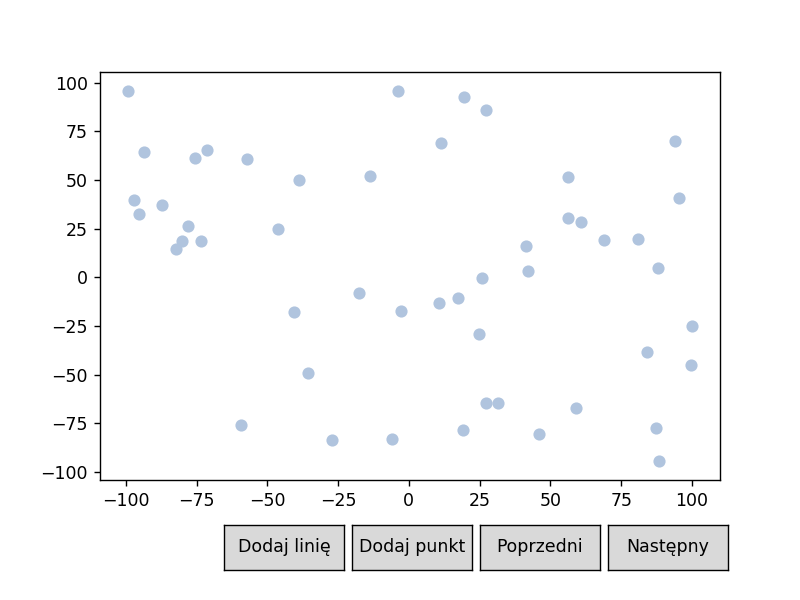

In [121]:
%matplotlib notebook

plot1 = Plot([Scene([PointsCollection(test1, color = 'lightsteelblue')])])
plot1.draw()

In [122]:
%matplotlib notebook

T = QuadTree()
T.build(test1)

<IPython.core.display.Javascript object>


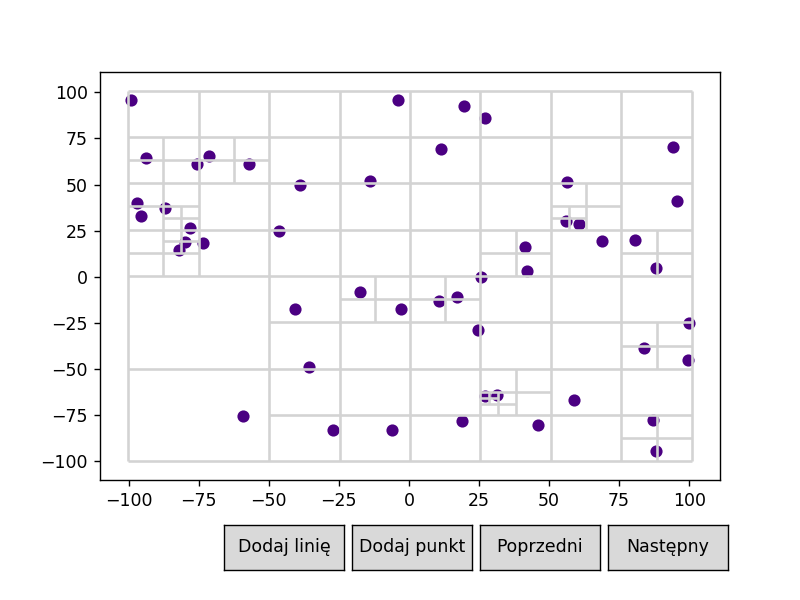

In [123]:
T.drawBuildingProcess()

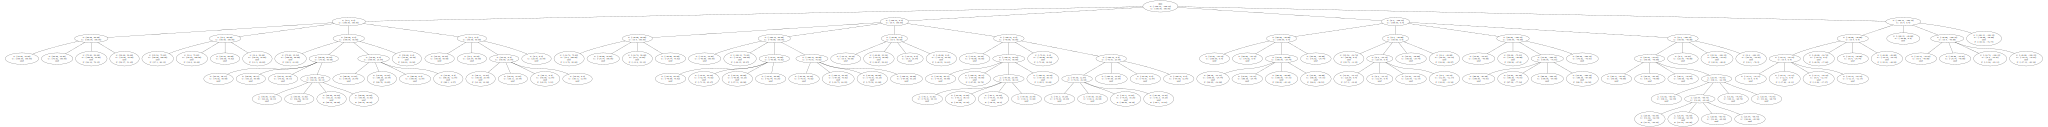

In [124]:
T.drawGraph()

In [125]:
print(T.searchPoints((30, 111), (-120, -35)))

[(99.6600382813046, -45.139942158016844), (83.9983408861033, -38.50985230350004), (58.96428318832167, -67.00353479633515), (87.27939720554326, -77.53771025745013), (88.31123208990468, -94.55868296160878), (31.512805235423826, -64.32742830858582), (45.90728616383123, -80.60266394246231)]


<IPython.core.display.Javascript object>


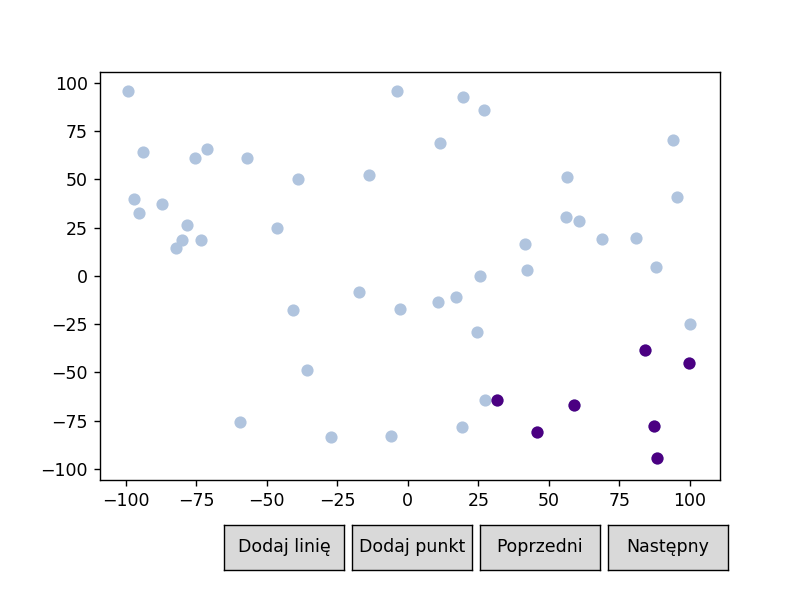

[(99.6600382813046, -45.139942158016844),
 (83.9983408861033, -38.50985230350004),
 (58.96428318832167, -67.00353479633515),
 (87.27939720554326, -77.53771025745013),
 (88.31123208990468, -94.55868296160878),
 (31.512805235423826, -64.32742830858582),
 (45.90728616383123, -80.60266394246231)]

In [126]:
%matplotlib notebook

T.searchPointsVisualization((30, 111), (-120, -35))